## Loading the Data

In [17]:
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
import tarfile
import os

# Load the metadata
metadata = pd.read_csv('meta_data.csv')

# Create a dictionary mapping from image file name to is_training_image
is_training_image = dict(zip(metadata.augmented_image_name, metadata.is_training_image))


directory = "../CUB_200_2011/images"
cropped_directory = '../cropped_images'

# Check if the directory exists
if os.path.isdir(directory):
    print("Directory exists skipping extraction")
else:
    print("Directory does not exist, extracting tgz file...")

    # Specify the tgz file name
    tgz_file = "../CUB_200_2011.tgz"

    # Specify the directory to extract to
    extract_dir = "../"

    # Open the tgz file in read mode
    with tarfile.open(tgz_file, 'r:gz') as tar:
        # Extract all the contents of the tgz file in the specified directory
        tar.extractall(extract_dir)

if(os.path.isdir(cropped_directory)):
    print("Cropped directory exists, skipping cropping")

else:
    os.mkdir(cropped_directory)

    from PIL import Image

    print("Cropping the images...")

    # Create a dictionary mapping from image file name to bounding box
    bounding_boxes = dict(zip(metadata.augmented_image_name, zip(metadata.bounding_x, metadata.bounding_y, metadata.bounding_x + metadata.bounding_width, metadata.bounding_y + metadata.bounding_height)))

    # Function to crop an image using a bounding box
    def crop_image(img_path, bbox):
        with Image.open(img_path) as img:
            cropped_img = img.crop(bbox)
        return cropped_img

    # Crop each image using the bounding box
    cropped_images = [(crop_image(os.path.join(directory, img), bbox), label, img.split('/')[1]) for img, bbox, label in zip(metadata.image_name, bounding_boxes.values(), metadata.class_name)]

    print("Saving the cropped images...")

    # Save the cropped images to disk
    for i, (img, label, name) in enumerate(cropped_images):
        img_dir = os.path.join(cropped_directory, str(label))
        os.makedirs(img_dir, exist_ok=True)
        img.save(os.path.join(img_dir, name))

print("Loading the dataset...")
# Load the dataset
dataset = ImageFolder(cropped_directory)

print("Splitting the dataset...")
# Split the dataset into training and testing sets
train_indices = [i for i, (img, label) in enumerate(dataset.imgs) if is_training_image[os.path.normpath(img).replace('\\', '/').replace("../", "./").replace("./cropped_images", "./augmented_images")]]
test_indices = [i for i, (img, label) in enumerate(dataset.imgs) if not is_training_image[os.path.normpath(img).replace('\\', '/').replace("../", "./").replace("./cropped_images", "./augmented_images")]]

Directory exists skipping extraction
Cropped directory exists, skipping cropping
Loading the dataset...
Splitting the dataset...


Label:  001.Black_footed_Albatross (0)


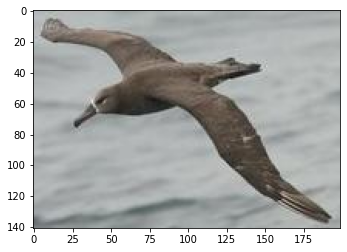

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img)

img, label = dataset[0]
show_example(img, label)

In [8]:
print("Train data size: ", len(train_indices))
print("Test data size: ", len(test_indices))

Train data size:  5994
Test data size:  5794


## Split Training Dataset into train and validation

In [9]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset, ConcatDataset, DataLoader
import numpy as np

# Define transformations for training and test sets, without Resize here, since cropping is first
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=45),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Get the labels of the test data
test_labels = np.array(dataset.targets)[test_indices]

# Split the test indices into extra and remaining subsets
extra_indices, remaining_indices = train_test_split(
    test_indices, test_size=0.5, stratify=test_labels)

# Split the remaining indices into validation and test subsets
val_indices, test_indices = train_test_split(
    remaining_indices, test_size=0.5, stratify=np.array(dataset.targets)[remaining_indices])

# Create subset datasets
train_dataset = Subset(dataset, train_indices)
extra_dataset = Subset(dataset, extra_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Apply transform to the datasets
train_dataset.dataset.transform = train_transform
extra_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = test_transform
test_dataset.dataset.transform = test_transform

# Create the data loader for training
train_loader = DataLoader(ConcatDataset([train_dataset, extra_dataset]), batch_size=16, shuffle=True)

# Create the data loaders for validation and test
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("Training set size: ", len(train_dataset) + len(extra_dataset))
print("Validation set size: ", len(val_dataset))
print("Test set size: ", len(test_dataset))

Training set size:  8891
Validation set size:  1448
Test set size:  1449


In [10]:
import torch
def get_class_distribution(dataset):
    if isinstance(dataset, torch.utils.data.Subset):
        return torch.bincount(torch.tensor(np.array(dataset.dataset.targets)[dataset.indices]))
    else:
        return torch.bincount(torch.tensor(dataset.targets))

train_class_distribution = get_class_distribution(train_dataset)
val_class_distribution = get_class_distribution(val_dataset)
test_class_distribution = get_class_distribution(test_dataset)

print("Training set class distribution: ", train_class_distribution)
print("Validation set class distribution: ", val_class_distribution)
print("Test set class distribution: ", test_class_distribution)
print("train class length: ", len(train_class_distribution))
print("val class length: ", len(val_class_distribution))
print("test class length: ", len(test_class_distribution))

Training set class distribution:  tensor([30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 29,
        30, 30, 30, 30, 30, 30, 30, 30, 29, 30, 30, 30, 30, 30, 29, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
        30, 30, 30, 30, 30, 30, 30, 30, 30, 29, 30, 30, 30, 30, 30, 29, 30, 30,
        30, 30])
Validation set class distribution:  tensor([8, 8, 7, 7, 4, 3, 6, 5, 8

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


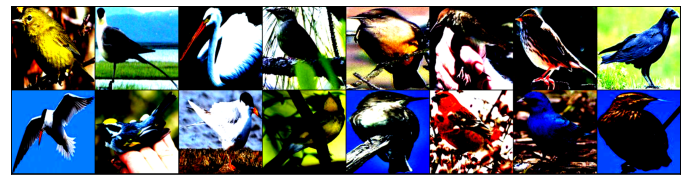

In [16]:
import torchvision.utils as vutils

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(vutils.make_grid(images, nrow=8).permute(1, 2, 0))
        break
show_batch(train_loader)

## EfficientNetB0 Transfer Learning Model Creation

In [17]:
import torch
from torch import nn
from torchvision.models import efficientnet_b0
import torch.nn.functional as F

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class BaseModel(nn.Module):
    def __init__(self):
        super(BaseModel, self).__init__()

    def training_step(self, batch):
        raise NotImplementedError

    def validation_step(self, batch):
        raise NotImplementedError

    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss']))

class EfficientNetModel(BaseModel):
    def __init__(self, num_classes):
        super().__init__()
        self.network = efficientnet_b0(pretrained=True)

        # Freeze all the parameters of the model
        for param in self.network.parameters():
            param.requires_grad = False

        # Unfreeze the last layer
        for param in list(self.network.parameters())[-1:]:
            param.requires_grad = True
        
        # Find the last linear layer in the classifier
        last_linear_layer = None
        for layer in reversed(self.network.classifier):
            if isinstance(layer, nn.Linear):
                last_linear_layer = layer
                break

        # Check if a linear layer was found
        if last_linear_layer is not None:
            num_ftrs = last_linear_layer.in_features
        else:
            raise ValueError("No linear layer found in classifier")

        # Add custom layers
        self.network.classifier = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128, num_classes)
        )

    def forward(self, xb):
        return self.network(xb)

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}

## Training the Model

In [18]:
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(dataset.classes)
model = EfficientNetModel(num_classes).to(device)

def fit(epochs, lr, train_loader, val_loader, optimizer):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    optimizer = optimizer(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        train_accs = []
        print("Starting epoch ", epoch+1, " of ", epochs)
        for batch in train_loader:
            inputs, labels = batch
            inputs = inputs.to(device)
            labels = labels.to(device)
            # Compute predictions and losses
            outputs = model(inputs)
            loss = model.training_step(batch)
            train_losses.append(loss.item())
            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            acc = torch.sum(preds == labels.data) / len(labels)
            train_accs.append(acc.item())
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        # Record training loss and accuracy
        history['train_loss'].append(np.mean(train_losses))
        history['train_acc'].append(np.mean(train_accs))

        # Validation phase
        model.eval()
        val_losses = []
        val_accs = []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)
                # Compute predictions and losses
                loss = model.validation_step(batch)['val_loss']
                val_losses.append(loss.item())
                # Compute accuracy
                acc = model.validation_step(batch)['val_acc']
                val_accs.append(acc.item())
        # Record validation loss and accuracy
        history['val_loss'].append(np.mean(val_losses))
        history['val_acc'].append(np.mean(val_accs))
        print(f'Epoch {epoch+1}/{epochs}, train loss: {np.mean(train_losses):.4f}, val loss: {np.mean(val_losses):.4f}, train acc: {np.mean(train_accs):.4f}, val acc: {np.mean(val_accs):.4f}')
    return history

C:\Users\wamik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\wamik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
num_epochs = 100
opt_func = torch.optim.Adam
lr = 0.0001
history = fit(num_epochs, lr, train_loader, val_loader, opt_func)

Starting epoch  1  of  100
Epoch 1/100, train loss: 5.2533, val loss: 5.1313, train acc: 0.0133, val acc: 0.0740
Starting epoch  2  of  100
Epoch 2/100, train loss: 4.9975, val loss: 4.7569, train acc: 0.0563, val acc: 0.1698
Starting epoch  3  of  100


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

    ax1.plot(history['train_loss'], label='train loss')
    ax1.plot(history['val_loss'], label='validation loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    ax2.plot(history['train_acc'], label='train accuracy')
    ax2.plot(history['val_acc'], label='validation accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

## Test the Model

In [ ]:
def test_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))

test_model(model, test_loader, device)

## Save the Model

In [ ]:
# Save the trained model
torch.save(model, 'efficientnet_b0.pth')